In [6]:
import enchant
from enchant.checker import SpellChecker
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd

In [7]:
def getNumMisspelled(text): 
    checker = SpellChecker('en_GB')    
    checker.set_text(text)
    return len(list(checker))

In [8]:
getNumMisspelled("This is a test")

0

In [9]:
soup = BeautifulSoup()

In [10]:
wake = open('../finnegans-wake-tei/finnegans-wake.xml').read()

In [11]:
soup = BeautifulSoup(wake)

In [12]:
wakeText = soup.get_text()[1055:]

In [13]:
len(wakeText)

1319621

In [24]:
binA = list(range(0, len(wakeText), round(len(wakeText)/50)))

In [25]:
ranges = list((zip(binA, binA[1:])))

In [26]:
segments = []
for i, j in ranges: 
    segments.append(wakeText[i:j])

In [27]:
misspelledN = [getNumMisspelled(seg) for seg in segments]

<AxesSubplot:>

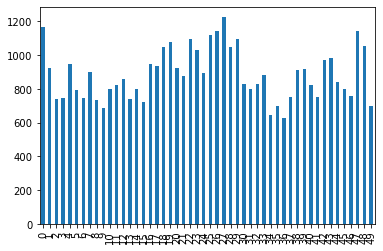

In [29]:
pd.Series(misspelledN).plot(kind='bar')